In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json
import os
import pandas as pd

# Load the JSON data
file_path = "/home/UNT/ae0589/project/action_engine/eval/scores/dag_scores.json"  # Replace with your file path
with open(file_path, 'r') as file:
    data = json.load(file)

In [2]:
# Extract data into a structured format
records = []
for entry in data:
    timestamp = entry["timestamp"]
    for score in entry["scores"]:
        for method, results in score.items():
            for level, metrics in results["results"].items():
                for metric, values in metrics.items():
                    records.append({
                        "timestamp": timestamp,
                        "method": method,
                        "level": level,
                        "metric": metric,
                        "value": values["value"],
                        "ci_lower": values["confidence_interval"][0],
                        "ci_upper": values["confidence_interval"][1]
                    })

# Convert to DataFrame
df = pd.DataFrame(records)

In [3]:
# Get unique timestamps from the DataFrame
unique_timestamps = df["timestamp"].unique()
# Display unique timestamps
unique_timestamps

array(['2025-01-16 10:29:38', '2025-01-15 19:58:40',
       '2025-01-15 19:56:53', '2025-01-15 19:54:42'], dtype=object)

In [ ]:
# Define the mapping of timestamps to labels
timestamp_labels = {
    "2025-01-15 19:58:40": "top-10",
    "2025-01-15 19:56:53": "top-20",
    "2025-01-15 19:54:42": "top-30",
    "2025-01-16 10:29:38": "top-40",
}

# Assign labels to the DataFrame based on the timestamp column
df["label"] = df["timestamp"].map(timestamp_labels)

df.head()

,timestamp,method,level,metric,value,ci_lower,ci_upper,label
0,2025-01-16 10:29:38,FewShot,testdata_level1,AMOUNT,1.000000,1.000000,1.000000,top-40
1,2025-01-16 10:29:38,FewShot,testdata_level1,P_api,0.306977,0.247638,0.375638,top-40
2,2025-01-16 10:29:38,FewShot,testdata_level1,R_api,0.352941,0.288732,0.422517,top-40
3,2025-01-16 10:29:38,FewShot,testdata_level1,F1_api,0.328358,0.268640,0.396948,top-40
4,2025-01-16 10:29:38,FewShot,testdata_level1,P_param,0.169533,0.120475,0.228577,top-40


In [5]:
df_filtered = df[~df["method"].isin(["ZeroShot", "ZeroShot CoT"])]
df_filtered = df_filtered[df_filtered["metric"].isin(["F1_api", "F1_param", "topological_ordering_accuracy"])]
df_filtered.drop(columns=["timestamp"], inplace=True)
df_filtered.drop(columns=["ci_lower", "ci_upper"], inplace=True)

In [8]:
label_order = ["top-10", "top-20", "top-30", "top-40"]
df_filtered["label"] = pd.Categorical(df_filtered["label"], categories=label_order, ordered=True)
df_filtered = df_filtered.sort_values(by="label")
df_filtered

,method,level,metric,value,label
239,Reverse Chain,testdata_level3,topological_ordering_accuracy,0.006169,top-10
187,FewShot CoT,testdata_level3,F1_api,0.412104,top-10
183,FewShot CoT,testdata_level2,topological_ordering_accuracy,0.264410,top-10
182,FewShot CoT,testdata_level2,F1_param,0.184444,top-10
179,FewShot CoT,testdata_level2,F1_api,0.342857,top-10
...,...,...,...,...,...
62,Action Engine,testdata_level2,F1_param,0.154989,top-40
59,Action Engine,testdata_level2,F1_api,0.393043,top-40
55,Action Engine,testdata_level1,topological_ordering_accuracy,0.288667,top-40
51,Action Engine,testdata_level1,F1_api,0.388769,top-40


/tmp/ipykernel_3042403/1426742533.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_methods)


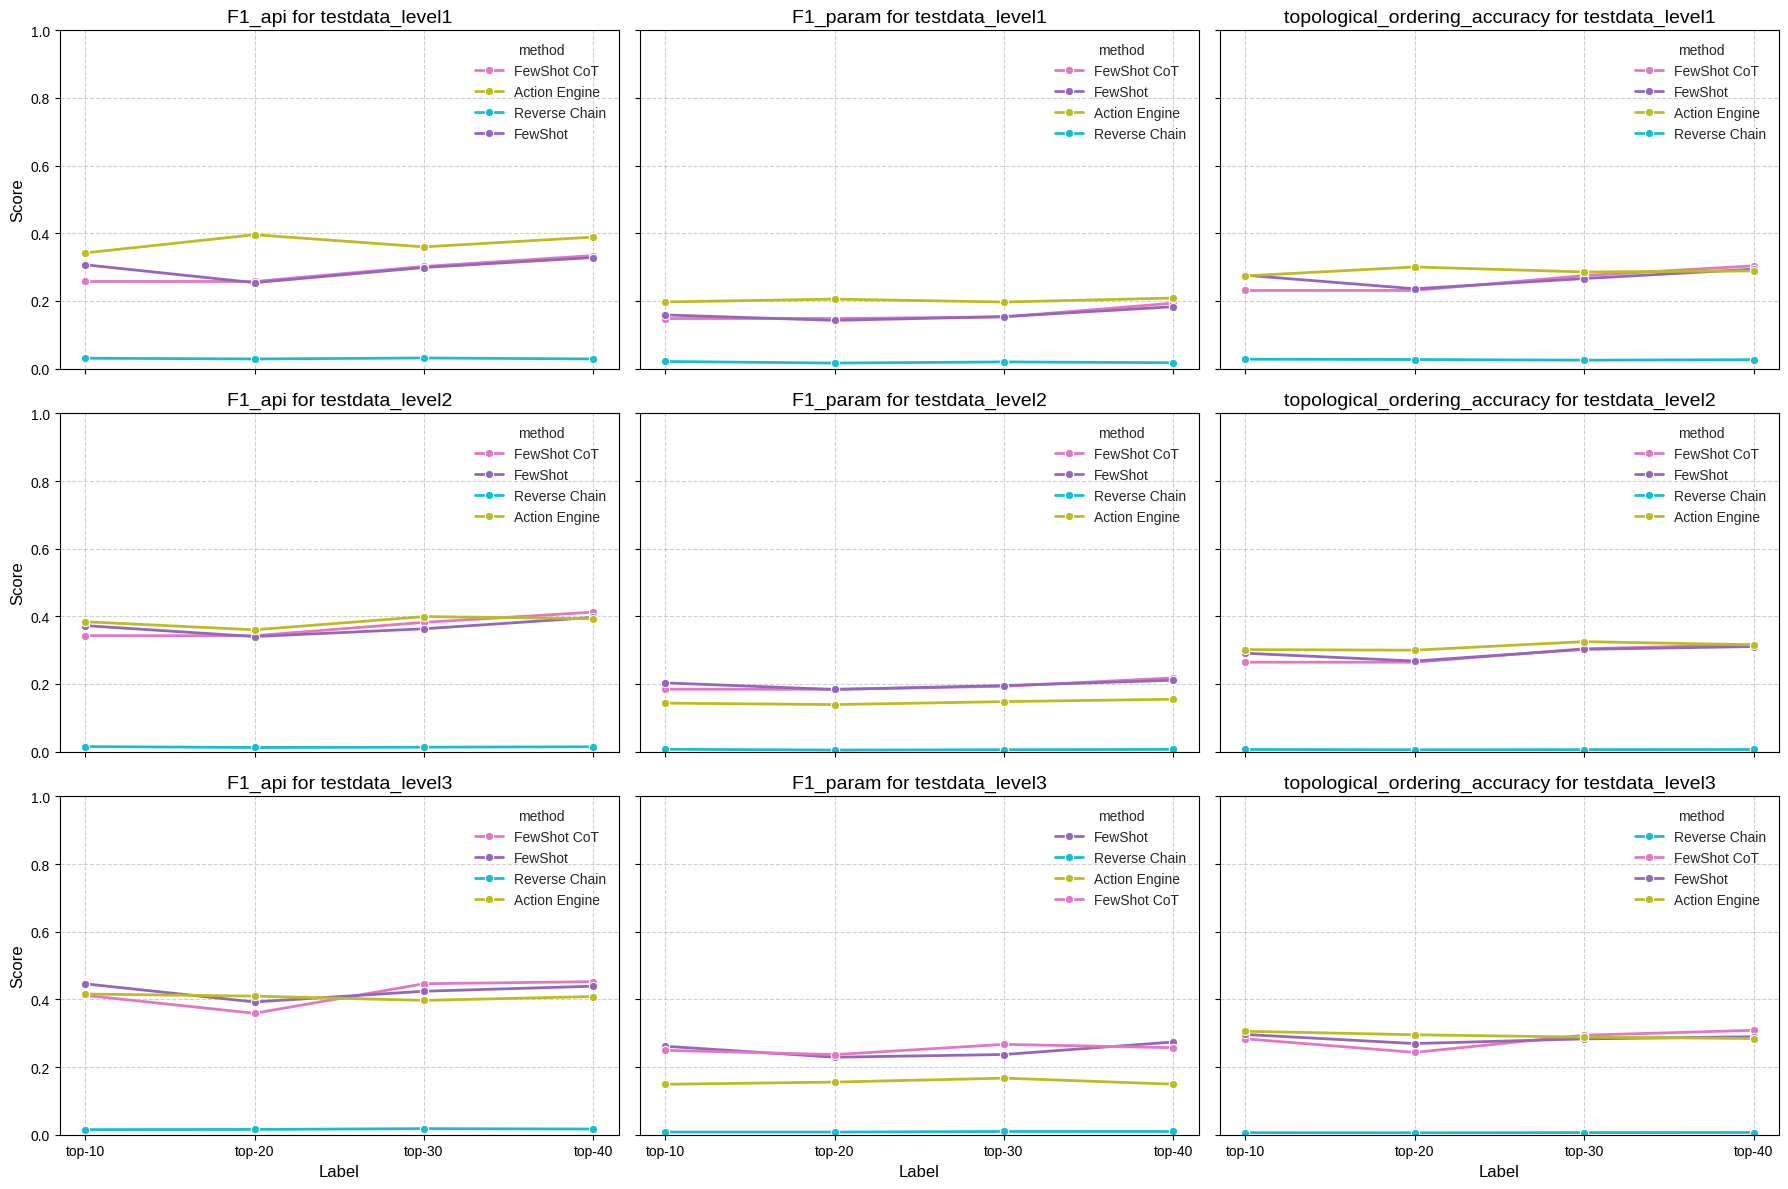

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define figure size and create subplots (3 rows x 3 columns)
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=True, sharey=True)

# Define levels and metrics
levels = ["testdata_level1", "testdata_level2", "testdata_level3"]
metrics = ["F1_api", "F1_param", "topological_ordering_accuracy"]

# Set Seaborn style
plt.style.use("seaborn-v0_8-whitegrid")

# Create a discrete color map for the number of methods
num_methods = 6
colors = plt.cm.get_cmap("tab10", num_methods)

# Define a color mapping for each method
color_mapping = {
    "ZeroShot": colors(0),  
    "ZeroShot CoT": colors(1),  
    "FewShot": colors(2), 
    "FewShot CoT": colors(3),  
    "Action Engine": colors(4),  
    "Reverse Chain": colors(5),  
}

# Loop through levels and metrics to create subplots
for row, level in enumerate(levels):
    for col, metric in enumerate(metrics):
        ax = axes[row, col]
        
        # Filter data for the current level and metric
        subset = df_filtered[(df_filtered["level"] == level) & (df_filtered["metric"] == metric)]
        
        # Plot data with specified colors
        sns.lineplot(
            data=subset, 
            x="label", 
            y="value", 
            hue="method", 
            marker="o", 
            linewidth=2, 
            ax=ax,
            palette=color_mapping  # Apply the custom color mapping
        )
        ax.set_ylim(0, 1)

        # Customize each subplot
        ax.set_title(f"{metric} for {level}", fontsize=14)
        ax.set_xlabel("Label", fontsize=12)
        ax.set_ylabel("Score", fontsize=12)
        ax.grid(True, linestyle="--", alpha=0.6)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

/tmp/ipykernel_3042403/2458402466.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", num_methods)


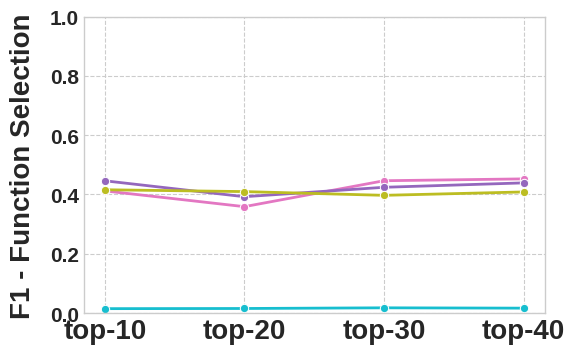

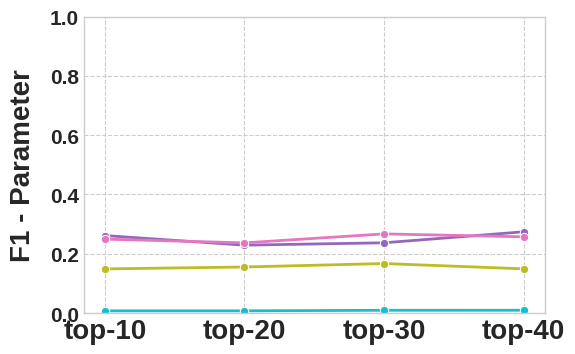

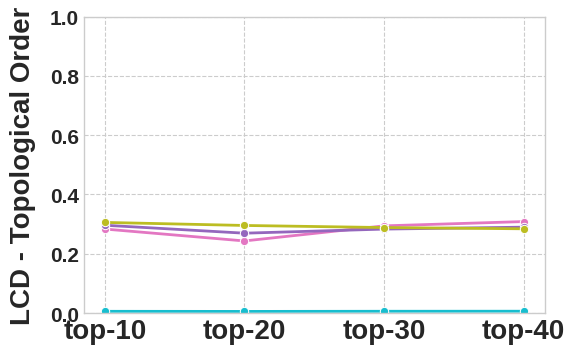

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Define metrics
metrics = ["F1_api", "F1_param", "topological_ordering_accuracy"]

# Set Seaborn style
plt.style.use("seaborn-v0_8-whitegrid")

# Create a discrete color map for the number of methods
num_methods = 6
colors = plt.cm.get_cmap("tab10", num_methods)

# Define a color mapping for each method
color_mapping = {
    "ZeroShot": colors(0),  
    "ZeroShot CoT": colors(1),  
    "FewShot": colors(2), 
    "FewShot CoT": colors(3),  
    "Action Engine": colors(4),  
    "Reverse Chain": colors(5),  
}

# Adjust global font settings
mpl.rcParams["font.size"] = 15
mpl.rcParams["axes.labelsize"] = 15
mpl.rcParams["axes.titlesize"] = 15
mpl.rcParams["xtick.labelsize"] = 20
mpl.rcParams["ytick.labelsize"] = 15
mpl.rcParams["legend.fontsize"] = 15
mpl.rcParams["font.weight"] = "black"
mpl.rcParams["axes.labelweight"] = "black"
mpl.rcParams["axes.titleweight"] = "black"
metric_mapping = {
    "P_api": "Precision - Function Selection",
    "R_api": "Recall - Function Selection",
    "F1_api": "F1 - Function Selection",
    "P_param": "Precision - Parameter",
    "R_param": "Recall - Parameter",
    "F1_param": "F1 - Parameter",
    "topological_ordering_accuracy": "LCD - Topological Order"
}
# Filter data only for Level 3
level = "testdata_level3"
# Directory to save plots
output_dir = "/home/UNT/ae0589/project/action_engine/eval/plots/linechart/"
os.makedirs(output_dir, exist_ok=True)
# Create separate plots for each metric
for metric in metrics:
    # Create a new figure for each plot
    plt.figure(figsize=(6, 4))

    # Filter data for the current metric
    subset = df_filtered[(df_filtered["level"] == level) & (df_filtered["metric"] == metric)]

    # Plot data with specified colors
    sns.lineplot(
        data=subset, 
        x="label", 
        y="value", 
        hue="method", 
        marker="o", 
        linewidth=2, 
        palette=color_mapping  # Apply the custom color mapping
    )
    
    # Set y-axis limit
    plt.ylim(0, 1)

    # Customize each plot
    # plt.title(f"{metric}", fontsize=20, weight="bold")
    plt.ylabel(metric_mapping[metric], fontsize=20, labelpad=10, weight='bold')
    plt.xlabel("", fontsize=15, weight="bold")

    # Remove legend if not needed
    plt.legend().remove()  

    # Add grid
    plt.grid(True, linestyle="--")
    # Tight layout and save the plot
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # Save as PDF
    output_file_pdf = os.path.join(output_dir, f"{metric}.pdf")
    plt.savefig(output_file_pdf, format='pdf', dpi=600)  # High DPI for clear text
    plt.close(fig)
    # Show each plot separately
    plt.show()

PassRate Table:

In [41]:
import pandas as pd
import re

# Input data as a multi-line string
data = """
Top-10
 96 passed level1 - FewShot
 89 passed level2 - FewShot
 91 passed level3 - FewShot
 99 passed level1 - FewShot-CoT
 96 passed level2 - FewShot-CoT
 99 passed level3 - FewShot-CoT
 100 passed level1 - ActionEngine
 99 passed level2 - ActionEngine
 100 passed level3 - ActionEngine
 73 passed level1 - ReverseChain
 86 passed level2 - ReverseChain
 59 passed level3 - ReverseChain

Top-20
 98 passed level1 - FewShot
 98 passed level2 - FewShot
 99 passed level3 - FewShot
 99 passed level1 - FewShot-CoT
 96 passed level2 - FewShot-CoT
 99 passed level3 - FewShot-CoT
 100 passed level1 - ActionEngine
 99 passed level2 - ActionEngine
 100 passed level3 - ActionEngine
 78 passed level1 - ReverseChain
 79 passed level2 - ReverseChain
 59 passed level3 - ReverseChain

Top-30
 93 passed level1 - FewShot
 87 passed level2 - FewShot
 84 passed level3 - FewShot
 97 passed level1 - FewShot-CoT
 92 passed level2 - FewShot-CoT
 98 passed level3 - FewShot-CoT
 100 passed level1 - ActionEngine
 99 passed level2 - ActionEngine
 100 passed level3 - ActionEngine
 85 passed level1 - ReverseChain
 84 passed level2 - ReverseChain
 57 passed level3 - ReverseChain

Top-40
 93 passed level1 - FewShot
 87 passed level2 - FewShot
 87 passed level3 - FewShot
 93 passed level1 - FewShot-CoT
 87 passed level2 - FewShot-CoT
 92 passed level3 - FewShot-CoT
 100 passed level1 - ActionEngine
 99 passed level2 - ActionEngine
 100 passed level3 - ActionEngine
 84 passed level1 - ReverseChain
 78 passed level2 - ReverseChain
 55 passed level3 - ReverseChain
"""


# Initialize empty list to store parsed data
parsed_data = []

# Regular expressions for parsing
top_regex = re.compile(r"Top-(\d+)")  # Match "Top-#" sections
entry_regex = re.compile(r"(\d+) passed (level\d+) - ([\w-]+)")  # Match "96 passed level1 - FewShot"

# Track the current "Top-#" value
current_top = None

# Process each line in the data
for line in data.split("\n"):
    line = line.strip()
    
    # Check if the line is a "Top-#" section
    top_match = top_regex.match(line)
    if top_match:
        current_top = f"top-{top_match.group(1)}"
        continue  # Move to next line

    # Check if the line contains a valid entry
    entry_match = entry_regex.match(line)
    if entry_match:
        pass_rate = int(entry_match.group(1))
        level = entry_match.group(2)
        method = entry_match.group(3)
        
        # Append extracted values to the list
        parsed_data.append([current_top, pass_rate, level, method])

# Convert to Pandas DataFrame
df = pd.DataFrame(parsed_data, columns=["label", "pass_rate", "level", "method"])


In [42]:
df.label.unique()

array(['top-10', 'top-20', 'top-30', 'top-40'], dtype=object)

/tmp/ipykernel_3042403/3693398722.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_level = df[df["level"] == level].pivot_table(index="method", columns="label", values="pass_rate", aggfunc="mean")  # Fix: Using pivot_table()
/tmp/ipykernel_3042403/3693398722.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_level = df[df["level"] == level].pivot_table(index="method", columns="label", values="pass_rate", aggfunc="mean")  # Fix: Using pivot_table()
/tmp/ipykernel_3042403/3693398722.py:15: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this

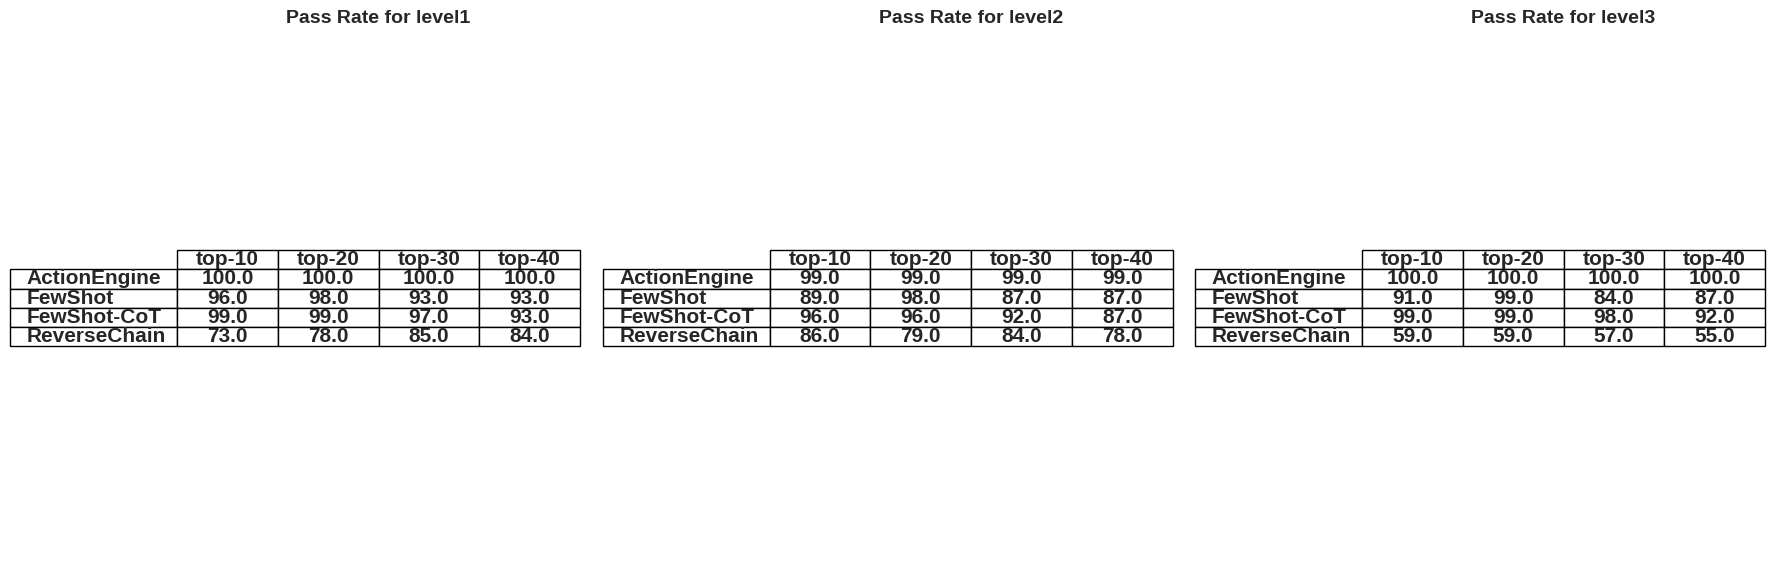

In [43]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert label column to categorical with specified order for sorting
df["label"] = pd.Categorical(df["label"], categories=["top-10", "top-20", "top-30", "top-40"], ordered=True)

# Get unique levels for separate tables
levels = df["level"].unique()

# Create a figure with 1 row and 3 columns for subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Loop through each level and create a pivot table with swapped columns and rows
for ax, level in zip(axes, levels):
    df_level = df[df["level"] == level].pivot_table(index="method", columns="label", values="pass_rate", aggfunc="mean")  # Fix: Using pivot_table()
    
    # Display table in subplot
    ax.axis("off")  # Hide axis
    table = ax.table(cellText=df_level.values, colLabels=df_level.columns, rowLabels=df_level.index,
                     cellLoc="center", loc="center")
    
    # Set title for each table
    ax.set_title(f"Pass Rate for {level}", fontsize=14, weight="bold")

# Adjust layout and display
plt.tight_layout()
plt.show()